## Amazon Fine Food Review - Decision Tree Algorithm

In [2]:
# Getting all the imports done

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import seaborn as sns

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect(r'C:\Users\NamrataT\Desktop\EXAM\PYTHON\Amazon Fine Food Reviews\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
filtered_data['Score'].value_counts()

1    83876
0    16124
Name: Score, dtype: int64

In [5]:
#Sorting data according to Time in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.reset_index(drop=True, inplace=True)

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

In [10]:
final_score = final['Score']
final_score.shape

(87773,)

In [11]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below','not','no', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [13]:
# Combining all the above stundents 
from tqdm import tqdm
from bs4 import BeautifulSoup

preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:54<00:00, 1599.63it/s]


In [14]:
# Processing the Summary column

preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:35<00:00, 2502.48it/s]


## 1) Applying Decision Tree

### 1.1) Applying Decision Tree on BOW, SET 1

In [15]:
# Getting all the imports done

from sklearn.metrics import accuracy_score
#from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
#from sklearn import cross_validation
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from scipy.sparse import hstack
import pydotplus
import graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
final['Cleaned_Text']=preprocessed_reviews
#final['Cleaned_Summary'] = preprocessed_summary
final['Word Count'] = final['Cleaned_Text'].apply(lambda x:len(x.split()))
#final['Summary Word Count'] = final['Cleaned_Summary'].apply(lambda x:len(x.split()))
final.head()
word_count = final['Word Count']

In [18]:
final_review = final[['Cleaned_Text','Word Count','Score']]
X = final_review.drop(['Score'],axis=1)
Y = final_review['Score']

In [19]:
# Time Series Split

X_1_train, X_test, Y_1_train, Y_test = train_test_split(X,Y,test_size=0.2,shuffle = False)
#X_1_train, X_1_cv, Y_1_train, Y_1_cv = train_test_split( X_1, Y_1, test_size=0.2,shuffle = False)
print(X_1_train.shape,Y_1_train.shape)

(70218, 2) (70218,)


In [20]:
df_post_split = pd.concat([X_1_train,Y_1_train],axis=1)
x_positive = df_post_split[df_post_split['Score']==1]
x_negetive = df_post_split[df_post_split['Score']==0]

In [21]:
df_post_split['Score'].value_counts()

1    58951
0    11267
Name: Score, dtype: int64

In [22]:
x_negative_downsample = resample(x_negetive,replace=True,n_samples=40000,random_state=123) 

In [23]:
print(x_negative_downsample.shape, type(x_positive))

(40000, 3) <class 'pandas.core.frame.DataFrame'>


In [24]:
df_upsample = pd.concat([x_positive,x_negative_downsample])
type(df_upsample)
df_upsample.head()

,Cleaned_Text,Word Count,Score
0,bought apartment infested fruit flies hours tr...,30,1
1,really good idea final product outstanding use...,17,1
2,received shipment could hardly wait try produc...,39,1
3,nothing product bother link top page buy used ...,16,1
4,love stuff sugar free rot gums tastes good goi...,12,1


In [25]:
df_upsample['Score'].value_counts()

1    58951
0    40000
Name: Score, dtype: int64

In [26]:
X_Train = df_upsample.drop(['Score'],axis=1)
Y_1_train = df_upsample['Score']
print(X_Train.shape, Y_1_train.shape)

(98951, 2) (98951,)


In [27]:
# Creating BOW Vectorizer

bow_vect = CountVectorizer(ngram_range=(1,2) , min_df = 10)
D1_Train = bow_vect.fit_transform(X_Train['Cleaned_Text'])
#D1_Cv = bow_vect.transform(X_1_cv['Cleaned_Text'])
D1_Test = bow_vect.transform(X_test['Cleaned_Text'])
print("Some feature names : ", bow_vect.get_feature_names()[0:10])
print(D1_Train.shape,D1_Test.shape)

Some feature names :  ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abc', 'abdominal', 'abdominal pain', 'abide', 'ability']
(98951, 67137) (17555, 67137)


In [112]:
'''X_Train_count  =  X_1['Word Count']
X_Test_count =    X_test['Word Count']
print(X_Train_count.shape,X_Test_count.shape)'''

"X_Train_count  =  X_1['Word Count']\nX_Test_count =    X_test['Word Count']\nprint(X_Train_count.shape,X_Test_count.shape)"

In [113]:
'''X_Train_count  =  X_1['Word Count'].values.reshape(-1,1)
X_Test_count = X_test['Word Count'].values.reshape(-1,1)'''

"X_Train_count  =  X_1['Word Count'].values.reshape(-1,1)\nX_Test_count = X_test['Word Count'].values.reshape(-1,1)"

In [114]:
#standardising word count feature
'''import warnings
warnings.filterwarnings('ignore')
word_scalar = StandardScaler()
word_scalar.fit(X_Train_count) 
X_Train_count = word_scalar.transform(X_Train_count)
X_Test_count = word_scalar.transform(X_Test_count)'''

"import warnings\nwarnings.filterwarnings('ignore')\nword_scalar = StandardScaler()\nword_scalar.fit(X_Train_count) \nX_Train_count = word_scalar.transform(X_Train_count)\nX_Test_count = word_scalar.transform(X_Test_count)"

In [115]:
#print(X_Train_count.shape,D1_Train.shape,X_Test_count.shape,D1_Test.shape)

In [116]:
'''from scipy.sparse import hstack
D1_Train = hstack((D1_Train,X_Train_count))
D1_Test = hstack((D1_Test,X_Test_count))'''

'from scipy.sparse import hstack\nD1_Train = hstack((D1_Train,X_Train_count))\nD1_Test = hstack((D1_Test,X_Test_count))'

In [28]:
#n_cv = D1_Cv.get_shape()[0]
n_train = D1_Train.get_shape()[0]
n_test = D1_Test.get_shape()[0]
print(n_train)

print(n_test)

98951
17555


In [117]:
'''from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
scaler.fit(D1_Train)
D1_Train = scaler.transform(D1_Train)
D1_Test = scaler.transform(D1_Test)

print(D1_Train.shape)
print(D1_Test.shape)'''

'from sklearn.preprocessing import MaxAbsScaler\nscaler = MaxAbsScaler()\nscaler.fit(D1_Train)\nD1_Train = scaler.transform(D1_Train)\nD1_Test = scaler.transform(D1_Test)\n\nprint(D1_Train.shape)\nprint(D1_Test.shape)'

In [61]:
'''D1_Train=D1_Train.astype('int')
D1_Test=D1_Test.astype('int')
Y_1=Y_1.astype('int')
Y_test=Y_test.astype('int')'''

In [29]:
tuned_param = [{'max_depth':[5,7,9,11,13,14,15,16],
               'min_samples_split':[5, 10, 100, 500]
               }]

In [30]:
# Using GridSearchCV
bow_model = GridSearchCV(DecisionTreeClassifier(class_weight = 'balanced', max_features = 'auto'),tuned_param,cv = 5, scoring = 'roc_auc')
bow_model.fit(D1_Train,Y_1_train)

print(bow_model.best_estimator_)
print("AUC SCORE : ",bow_model.score(D1_Test,Y_test))

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
AUC SCORE :  0.5824123003925992


In [31]:
results = bow_model.cv_results_
print(results)

{'mean_fit_time': array([0.42621121, 0.3897644 , 0.39655566, 0.39455667, 0.4037519 ,
       0.39775434, 0.4085495 , 0.40215287, 0.41222634, 0.44340219,
       0.42174044, 0.40415139, 0.43053365, 0.41214643, 0.42154069,
       0.41814356, 0.44672427, 0.44133759, 0.43010535, 0.41321115,
       0.45452065, 0.44732499, 0.43633113, 0.46071591, 0.45731754,
       0.44032807, 0.44392548, 0.42993503, 0.45671763, 0.44912262,
       0.44018173, 0.43876905]), 'std_fit_time': array([0.06393248, 0.0133113 , 0.01931009, 0.01272545, 0.02502909,
       0.01273382, 0.02318404, 0.01415628, 0.01875363, 0.04362099,
       0.02557264, 0.01847738, 0.03667935, 0.01071916, 0.02491206,
       0.02872584, 0.04126905, 0.03070229, 0.04089978, 0.01540549,
       0.04261406, 0.04378417, 0.03091025, 0.05080909, 0.04399063,
       0.01756795, 0.04575901, 0.03412354, 0.04369959, 0.0281581 ,
       0.03351089, 0.05089859]), 'mean_score_time': array([0.13493724, 0.07258921, 0.07155752, 0.07195663, 0.07155623,
       0.0

       0.01805315, 0.03094977])}


In [32]:
X_axis = np.array(results['param_min_samples_split'].data, dtype=float)
Y_axis = np.array(results['param_max_depth'].data, dtype=float)

Text(0.5,1,'Train AUC HeatMap')

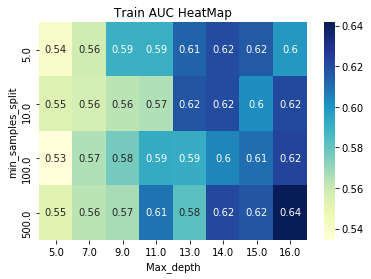

In [33]:
import seaborn as sns
pvt_test = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#pvt_train = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#fig,ax = plt.subplots(1,2)
sns.heatmap(pvt_test,annot = True,cmap="YlGnBu")
#sns.heatmap(pvt_train,annot = True, ax = ax[1],cmap="YlGnBu")
plt.xlabel('Max_depth')
plt.ylabel('min_samples_split')
plt.title('Train AUC HeatMap')

Text(0.5,1,'CV AUC HeatMap')

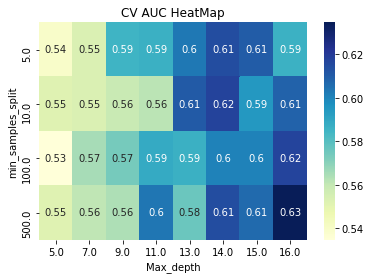

In [34]:

pvt_test = pd.pivot_table(pd.DataFrame(results),values='mean_test_score', index=X_axis, columns=Y_axis)
#pvt_train = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#fig,ax = plt.subplots(1,2)
sns.heatmap(pvt_test,annot = True,cmap="YlGnBu")
#sns.heatmap(pvt_train,annot = True, ax = ax[1],cmap="YlGnBu")
plt.xlabel('Max_depth')
plt.ylabel('min_samples_split')
plt.title('CV AUC HeatMap')

In [135]:
#best_paramList = bow_model.best_params_

In [72]:
# Fitting the model on test data

test_neigh = DecisionTreeClassifier(class_weight = 'balanced' , max_depth = 15,min_samples_split=500)
#test_neigh.set_params(**best_paramList)
test_neigh.fit(D1_Train,Y_1_train)

predict_test_prob = []
predict_train_prob = []
predicted_labels_test = []
predicted_labels_train = []

# Predicting the model with Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(test_neigh.predict(D1_Test[j:j+1000]))
    predict_test_prob.extend(test_neigh.predict_proba(D1_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(test_neigh.predict(D1_Train[k:k+1000]))
    predict_train_prob.extend(test_neigh.predict_proba(D1_Train[k:k+1000])[:,1])
    
print(len(predict_train_prob))
print(len(Y_1_train))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1_train,predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)

98951
98951
Algo Run Successfully on D_Test


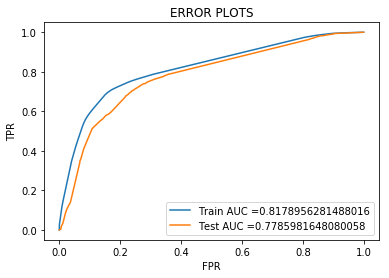

In [73]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [74]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1_train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1_train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
33324 6676 17450 41501
[[33324  6676]
 [17450 41501]]
Test Confusion Matrix
2227 687 4418 10223
[[ 2227   687]
 [ 4418 10223]]


Text(0.5,1,'Confusion Matrix of Train Data')

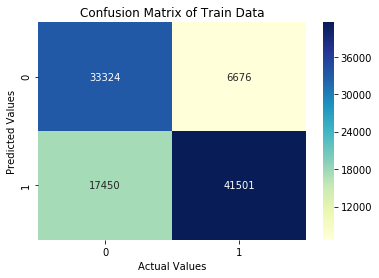

In [75]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

Text(0.5,1,'Confusion Matrix of Test Data')

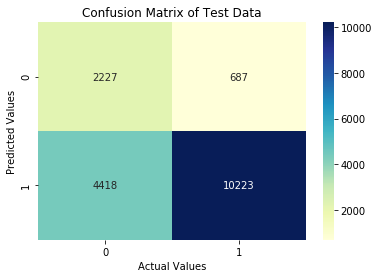

In [76]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Test Data')

##### Feature Importance

In [77]:
importances = test_neigh.feature_importances_
indices = np.argsort(importances)[::-1][0:20]
print(indices)
features = bow_vect.get_feature_names()
print(len(features))
top20_features = []
feature_importance_top20 = []
for i in indices:
    top20_features.append(features[i])
    feature_importance_top20.append(importances[i])
feature_df = pd.DataFrame(data = top20_features, columns = ['Feature Name'])
feat_imp_df = pd.DataFrame( data = feature_importance_top20 , columns = ['Feature Importance'])
dt_feature_df = pd.concat([feature_df,feat_imp_df],axis = 1)
print(dt_feature_df)

[26498  4919 14868 34468 34877 15740 43333 66226  3622 25503 19279 20309
 37628 39200 59737 65872 57372 45575 58133 62406]
67137
     Feature Name  Feature Importance
0           great            0.159968
1            best            0.066653
2       delicious            0.062412
3            love            0.050954
4           loves            0.042054
5    disappointed            0.038503
6         perfect            0.037814
7           would            0.037651
8             bad            0.029875
9            good            0.029485
10      excellent            0.026513
11       favorite            0.024070
12          money            0.023395
13           nice            0.022981
14        thought            0.021757
15      wonderful            0.019243
16          taste            0.017573
17        product            0.015851
18          tasty            0.013274
19  unfortunately            0.012151


##### Visualising Decision Tree with Graphviz

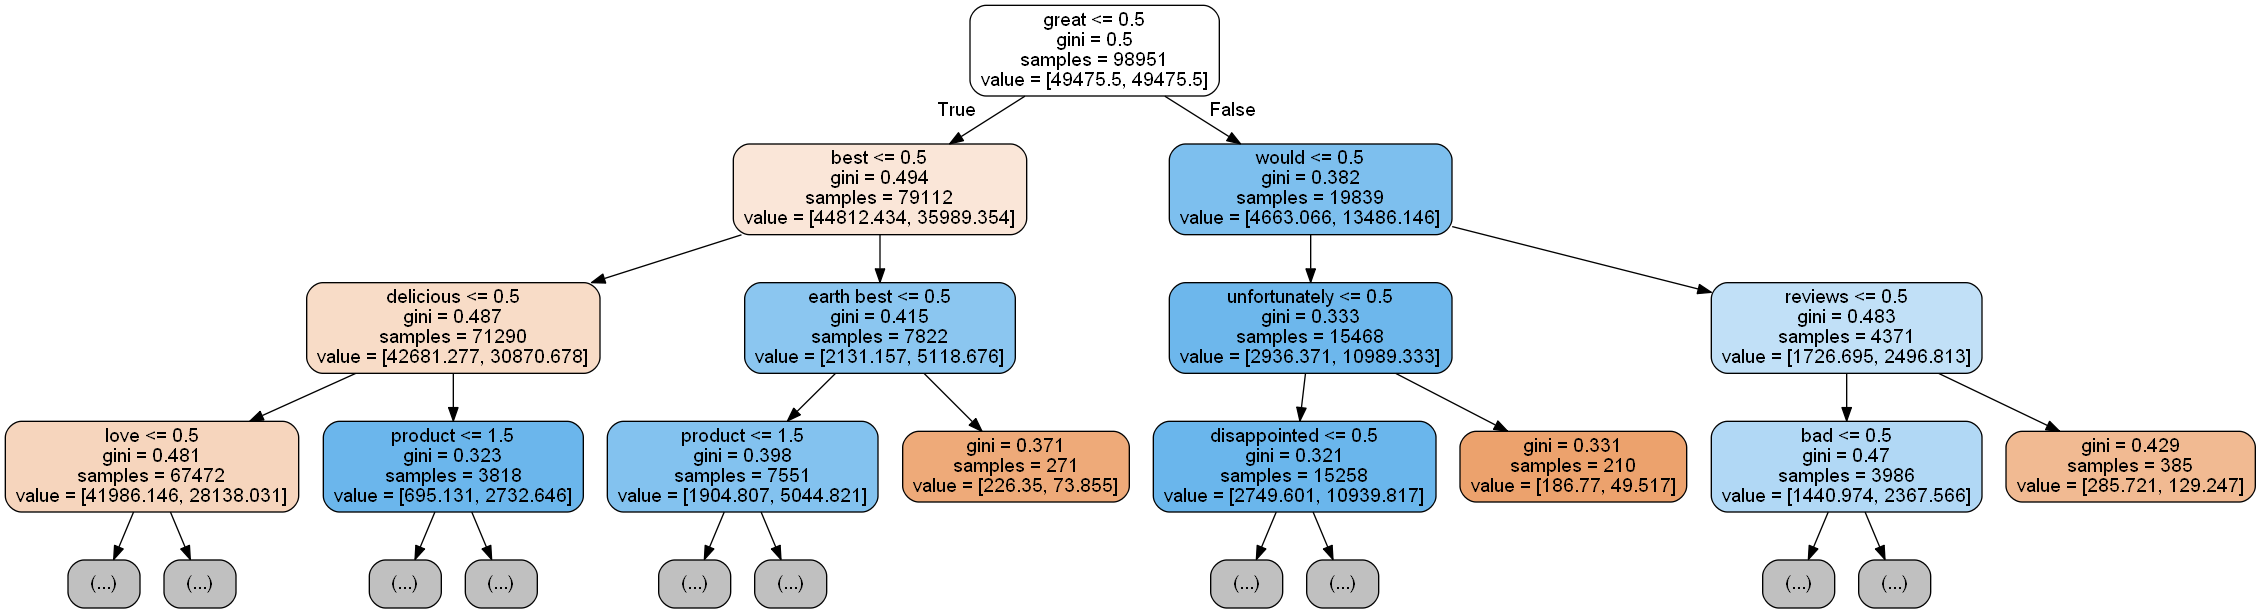

'with open("C:/Users/NamrataT/Desktop/tree.txt", "w") as f:\n    dot_graph = tree.export_graphviz(test_neigh,out_file=f,max_depth = 3,feature_names=features,filled=True,rounded=True)'

In [78]:
dot_data = StringIO()
tree.export_graphviz(test_neigh,out_file = dot_data,max_depth = 3,feature_names=features,filled=True,rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
graph.write_png("dtree.png")
display(Image(filename="dtree.png"))

'''with open("C:/Users/NamrataT/Desktop/tree.txt", "w") as f:
    dot_graph = tree.export_graphviz(test_neigh,out_file=f,max_depth = 3,feature_names=features,filled=True,rounded=True)'''

## 1.2) Applying Logistic Regression on TF-IDF, SET 2

In [42]:
# Creating Tfidf Vectorizer

tfidf_vect = TfidfVectorizer(ngram_range=(1,2) , min_df = 10)
D2_Train = tfidf_vect.fit_transform(X_Train['Cleaned_Text'])
#D2_Cv = tfidf_vect.transform(X_1_cv['Cleaned_Text'])
D2_Test = tfidf_vect.transform(X_test['Cleaned_Text'])
print("Some feature names : ", tfidf_vect.get_feature_names()[0:10])
print(D2_Train.shape,D2_Test.shape)

Some feature names :  ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abc', 'abdominal', 'abdominal pain', 'abide', 'ability']
(98951, 67137) (17555, 67137)


In [60]:
'''X_Train_summary_count  =  X_1['Summary Word Count'].values.reshape(-1,1)
X_Test_summary_count = X_test['Summary Word Count'].values.reshape(-1,1)'''

In [61]:
#standardising word count feature
'''import warnings
warnings.filterwarnings('ignore')
summary_scalar = StandardScaler()
summary_scalar.fit(X_Train_summary_count) 
X_Train_summary_count = summary_scalar.transform(X_Train_summary_count)
X_Test_summary_count = summary_scalar.transform(X_Test_summary_count)'''

In [52]:
'''D2_Train = hstack((D2_Train,X_Train_summary_count))
D2_Test = hstack((D2_Test,X_Test_summary_count))'''

In [43]:
n_train = D2_Train.get_shape()[0]
n_test = D2_Test.get_shape()[0]
print(n_train)
print(n_test)

98951
17555


In [121]:
'''from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
scaler.fit(D2_Train)
D2_Train = scaler.transform(D2_Train)
D2_Test = scaler.transform(D2_Test)

print(D2_Train.shape)
print(D2_Test.shape)'''

'from sklearn.preprocessing import MaxAbsScaler\nscaler = MaxAbsScaler()\nscaler.fit(D2_Train)\nD2_Train = scaler.transform(D2_Train)\nD2_Test = scaler.transform(D2_Test)\n\nprint(D2_Train.shape)\nprint(D2_Test.shape)'

In [122]:
'''D2_Train=D2_Train.astype('int')
D2_Test=D2_Test.astype('int')
Y_1=Y_1.astype('int')
Y_test=Y_test.astype('int')'''

"D2_Train=D2_Train.astype('int')\nD2_Test=D2_Test.astype('int')\nY_1=Y_1.astype('int')\nY_test=Y_test.astype('int')"

In [44]:
# Using GridSearchCV
tfidf_model = GridSearchCV(DecisionTreeClassifier(class_weight = 'balanced', max_features = 'auto'),tuned_param,cv = 5, scoring = 'roc_auc')
tfidf_model.fit(D2_Train,Y_1_train)

print(tfidf_model.best_estimator_)
print("AUC SCORE : ",tfidf_model.score(D2_Test,Y_test))

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
AUC SCORE :  0.6196465890556492


In [45]:
tfidf_results = tfidf_model.cv_results_
print(tfidf_results)

{'mean_fit_time': array([0.40204897, 0.40503597, 0.39535646, 0.40415106, 0.41094756,
       0.40535111, 0.40654931, 0.40554934, 0.41634383, 0.4201416 ,
       0.41614437, 0.40934896, 0.43457642, 0.43534198, 0.43912826,
       0.42094059, 0.4405283 , 0.45491896, 0.43533297, 0.44272771,
       0.46713495, 0.46195831, 0.45731807, 0.43065314, 0.46947947,
       0.47231355, 0.45969095, 0.45390472, 0.47510738, 0.47730575,
       0.46531191, 0.45352178]), 'std_fit_time': array([0.01448528, 0.02548727, 0.01022255, 0.02183785, 0.02127995,
       0.01648987, 0.01571781, 0.01493582, 0.00754708, 0.01610982,
       0.01484543, 0.01862887, 0.01873515, 0.03393682, 0.04339038,
       0.01750958, 0.02677378, 0.03995109, 0.01290164, 0.03732367,
       0.03742039, 0.0355403 , 0.03674968, 0.02736764, 0.02329824,
       0.02796416, 0.03457681, 0.04890076, 0.04077004, 0.05043767,
       0.03874438, 0.04029126]), 'mean_score_time': array([0.07283254, 0.07476239, 0.071557  , 0.07435579, 0.07435522,
       0.0

       0.02472403, 0.02570816])}


In [46]:
Y_axis = np.array(tfidf_results['param_max_depth'].data, dtype='float')
X_axis = np.array(tfidf_results['param_min_samples_split'].data, dtype='float')

Text(0.5,1,'TFIDF Train AUC HeatMap')

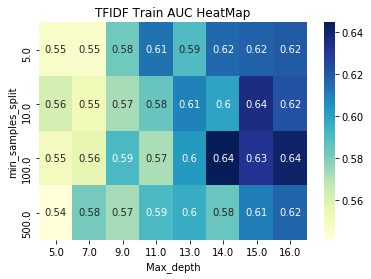

In [47]:
pvt_test = pd.pivot_table(pd.DataFrame(tfidf_results),values='mean_train_score', index=X_axis, columns=Y_axis)
#pvt_train = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#fig,ax = plt.subplots(1,2)
sns.heatmap(pvt_test,annot = True,cmap="YlGnBu")
#sns.heatmap(pvt_train,annot = True, ax = ax[1],cmap="YlGnBu")
plt.xlabel('Max_depth')
plt.ylabel('min_samples_split')
plt.title('TFIDF Train AUC HeatMap')

Text(0.5,1,'TFIDF Test AUC HeatMap')

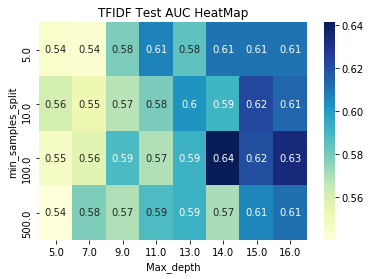

In [48]:
pvt_test = pd.pivot_table(pd.DataFrame(tfidf_results),values='mean_test_score', index=X_axis, columns=Y_axis)
#pvt_train = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#fig,ax = plt.subplots(1,2)
sns.heatmap(pvt_test,annot = True,cmap="YlGnBu")
#sns.heatmap(pvt_train,annot = True, ax = ax[1],cmap="YlGnBu")
plt.xlabel('Max_depth')
plt.ylabel('min_samples_split')
plt.title('TFIDF Test AUC HeatMap')

In [79]:
# Fitting the model on test data

test_neigh_tfidf = DecisionTreeClassifier(class_weight = 'balanced' , max_depth = 15,min_samples_split=100)
#test_neigh.set_params(**best_paramList)
test_neigh_tfidf.fit(D2_Train,Y_1_train)

predict_test_prob = []
predict_train_prob = []
predicted_labels_test = []
predicted_labels_train = []

# Predicting the model with Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(test_neigh_tfidf.predict(D2_Test[j:j+1000]))
    predict_test_prob.extend(test_neigh_tfidf.predict_proba(D2_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(test_neigh_tfidf.predict(D2_Train[k:k+1000]))
    predict_train_prob.extend(test_neigh_tfidf.predict_proba(D2_Train[k:k+1000])[:,1])
    
print(len(predict_test_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1_train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)

17555
17555
Algo Run Successfully on D_Test


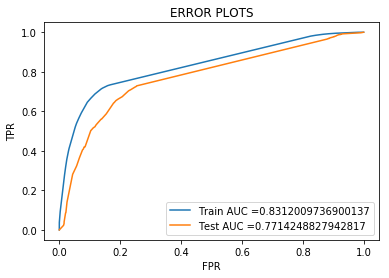

In [80]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [81]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1_train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1_train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
34488 5512 16898 42053
[[34488  5512]
 [16898 42053]]
Test Confusion Matrix
2247 667 4323 10318
[[ 2247   667]
 [ 4323 10318]]


Text(0.5,1,'Confusion Matrix of Train Data')

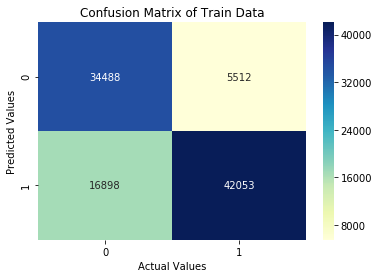

In [82]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

Text(0.5,1,'Confusion Matrix of Test Data')

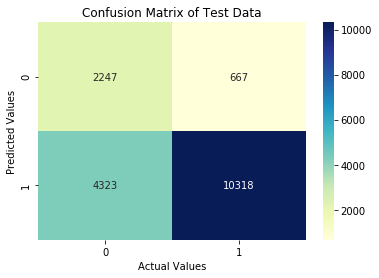

In [83]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Test Data')

##### Feature Importance

In [84]:
importances = test_neigh_tfidf.feature_importances_
indices = np.argsort(importances)[::-1][0:20]
print(indices)
features_tfidf = tfidf_vect.get_feature_names()
top20_features = []
feature_importance_top20 = []
for i in indices:
    top20_features.append(features_tfidf[i])
    feature_importance_top20.append(importances[i])
feature_df = pd.DataFrame(data = top20_features, columns = ['Feature Name'])
feat_imp_df = pd.DataFrame( data = feature_importance_top20 , columns = ['Feature Importance'])
dt_feature_df = pd.concat([feature_df,feat_imp_df],axis = 1)
print(dt_feature_df)

[26498  4919 14868 34468 25503 34877 15740 43333 39200 20309 19279 28201
 65872  3622 57372 58133  1697 62406 49219 59737]
     Feature Name  Feature Importance
0           great            0.170956
1            best            0.072293
2       delicious            0.063093
3            love            0.060632
4            good            0.046709
5           loves            0.041691
6    disappointed            0.036977
7         perfect            0.036915
8            nice            0.028800
9        favorite            0.028578
10      excellent            0.028433
11         highly            0.019489
12      wonderful            0.016494
13            bad            0.016438
14          taste            0.014988
15          tasty            0.014970
16        amazing            0.013214
17  unfortunately            0.012225
18        reviews            0.011366
19        thought            0.009112


##### Visualising Decision Tree with Graphviz

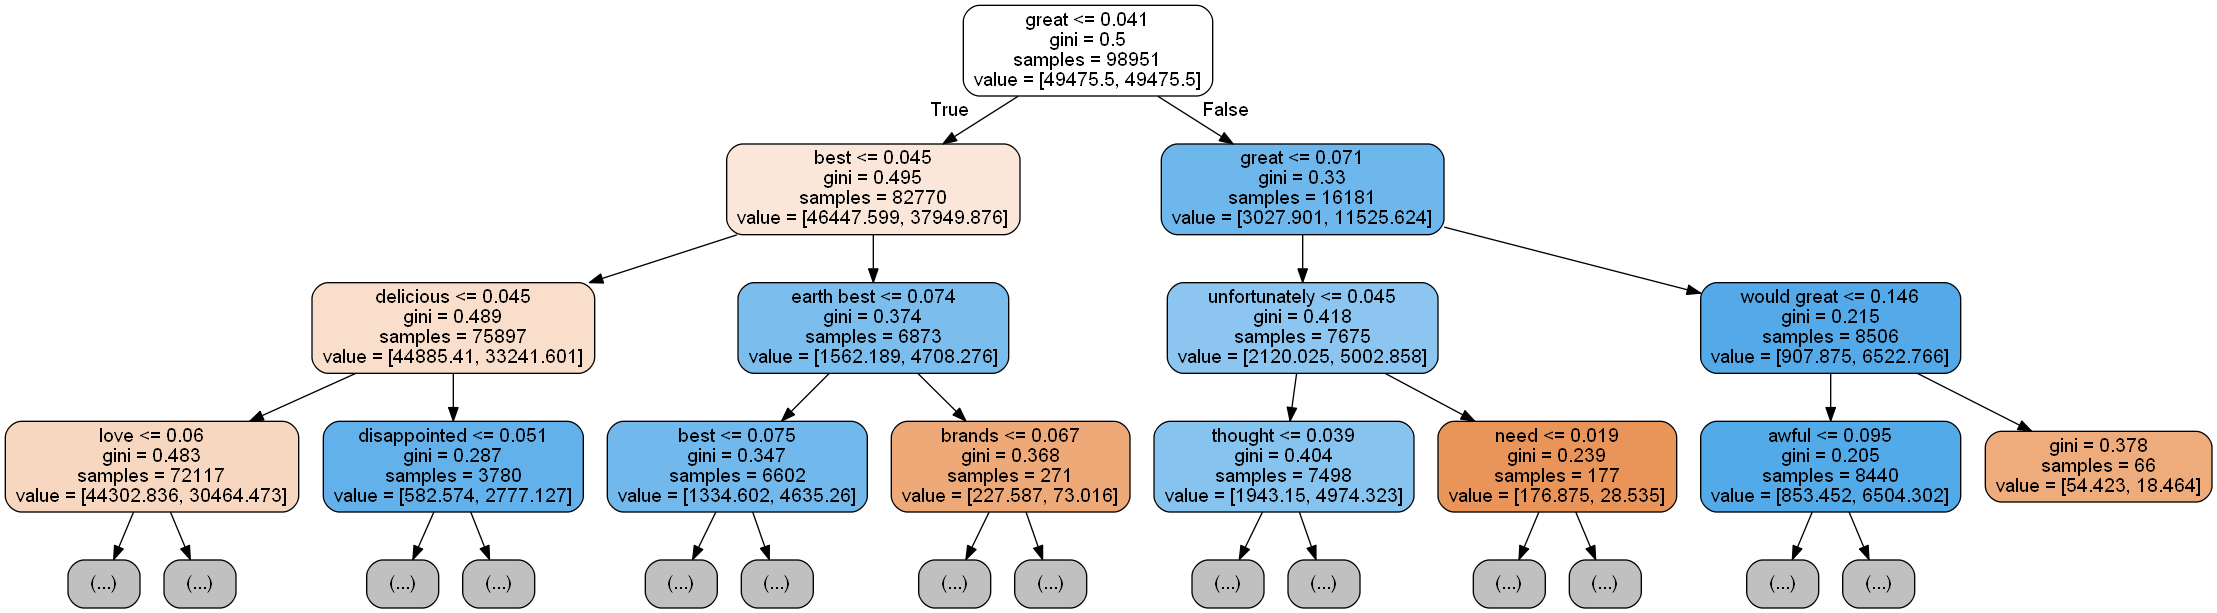

In [85]:
dot_data = StringIO()
tree.export_graphviz(test_neigh_tfidf,out_file = dot_data,max_depth = 3,feature_names=features_tfidf,filled=True,rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
graph.write_png("dtree_tfidf.png")
display(Image(filename="dtree_tfidf.png"))

## 1.3) Applying Decision Tree on Average_Word2Vec, SET 3

In [62]:
# Creating Word2Vec model on Training Data 

list_of_sentence = []
for sentence in X_Train['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

# Creating Word2Vec model with 50 dimension and min_count=5, it will consider the word only if it appeared more than 5 times

w2v_model = Word2Vec(list_of_sentence, min_count=5, size=50, workers=4)
print(w2v_model.wv.most_similar("good"))
print("="*100)

w2v_words = list(w2v_model.wv.vocab)
print("Total Words Present ", len(w2v_words))
print("Sample Words : ", w2v_words[0:10])
print("="*100)

98951
[('decent', 0.8470034599304199), ('great', 0.8306916952133179), ('fantastic', 0.757225513458252), ('terrific', 0.7528927326202393), ('amazing', 0.7491506338119507), ('awesome', 0.7301520109176636), ('bad', 0.6957558393478394), ('excellent', 0.6870042681694031), ('delicious', 0.6319735646247864), ('yummy', 0.6299095153808594)]
Total Words Present  19693
Sample Words :  ['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'within']


In [63]:
# Fitting Average Word2Vec Model on Train Data

sent_vect_train = []
for sent in tqdm(list_of_sentence):
    sentence_vec = np.zeros(50)
    count_words = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            count_words += 1
            sentence_vec += vec
    if count_words != 0:
        sentence_vec /= count_words
    sent_vect_train.append(sentence_vec)
print(len(sent_vect_train))
print(sent_vect_train[0])

100%|███████████████████████████████████████████████████████████████████████████| 98951/98951 [06:14<00:00, 264.10it/s]


98951
[ 0.81848061 -0.09356646  0.10516658  0.50236275  0.62912432  0.10577743
  0.5650384  -0.61676295 -0.20705489  0.34350221  1.12443793 -0.26810447
  0.22786616 -0.04086422 -0.09238459  0.32337312  0.13554265 -0.37822019
 -0.53665655 -0.65791828 -0.4473433   0.65619622  0.21297765 -0.48268443
  0.14800604 -0.18065831 -0.26626851 -0.41422949 -0.28066447  0.00866173
  0.08427032 -0.28882821  0.42339468 -0.01662317 -0.39206505 -0.33586274
 -0.05928682 -0.20822559  0.12043453  0.43055778 -0.65656313  0.58713118
 -0.06928739 -0.50197227 -0.49990529 -0.15223455 -0.03338001  0.23248684
  0.07952904  0.30877971]


In [64]:
# Applying Word2Vec for Vectorization of X_test

list_of_sentence = []
for sentence in X_test['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

17555


In [65]:
# Creating Average Word2Vec Vector for Test Data

sent_vect_test = []
for sent in tqdm(list_of_sentence):
    sentence_vec = np.zeros(50)
    count_words = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            count_words += 1
            sentence_vec += vec
    if count_words != 0:
        sentence_vec /= count_words
    sent_vect_test.append(sentence_vec)
print(len(sent_vect_test))
print(sent_vect_test[0])

100%|███████████████████████████████████████████████████████████████████████████| 17555/17555 [01:04<00:00, 273.58it/s]


17555
[ 0.18593039 -0.49870062  0.09622276 -0.28707183  0.68931988 -0.56215587
 -0.2583868  -1.11973443  0.07839879  1.06730983  0.03412346 -0.63836802
  0.9066741   0.38886039  0.666961    0.18962985 -0.29848544 -0.21103501
 -0.31249712 -0.14870963  0.13150831  0.25378584 -0.16054847  0.51940527
  0.37572688  0.43041494 -0.63268318 -0.15810309 -0.62703321  0.54725745
 -0.15331787  0.68614265  0.39007083  1.05581324 -0.75930513 -0.64645254
  0.57033526 -0.59370252 -1.00319576  0.18800763 -0.66918344  0.58118139
  0.56223266  0.16216905 -0.68551394 -0.57132012  0.29630842  0.01640779
  0.49799077 -0.06711063]


In [66]:
n_train = len(sent_vect_train)
n_test = len(sent_vect_test)
print(n_train)
print(n_test)

98951
17555


In [67]:
# Using GridSearchCV
w2v_model_gs = GridSearchCV(DecisionTreeClassifier(class_weight = 'balanced' , max_features = 'auto'),tuned_param,cv = 5, scoring = 'roc_auc')
w2v_model_gs.fit(sent_vect_train,Y_1_train)

print(w2v_model_gs.best_estimator_)
print("AUC SCORE : ",w2v_model_gs.score(sent_vect_test,Y_test))

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
AUC SCORE :  0.6527371729065204


In [68]:
w2v_results = w2v_model_gs.cv_results_
print(w2v_results)

{'mean_fit_time': array([0.64093795, 0.57498007, 0.58064775, 0.59555907, 0.73233657,
       0.74194918, 0.73794599, 0.72858953, 0.87679758, 0.86659594,
       0.87320495, 0.84137864, 0.99398694, 0.99778066, 0.9813869 ,
       0.9268558 , 1.13813443, 1.08235168, 1.06271143, 0.9158926 ,
       1.13155308, 1.14114799, 1.08763795, 0.94301052, 1.1629251 ,
       1.18555422, 1.13746424, 1.0005609 , 1.22894239, 1.17758641,
       1.12816658, 0.95379224]), 'std_fit_time': array([0.09522542, 0.00625184, 0.00663516, 0.02777138, 0.01067707,
       0.00642201, 0.02259271, 0.00810461, 0.0073411 , 0.00707488,
       0.00864562, 0.01841904, 0.0123065 , 0.00680098, 0.00634134,
       0.02967963, 0.03778102, 0.00637655, 0.01370134, 0.01266377,
       0.0139246 , 0.01431415, 0.01600876, 0.01636152, 0.01623252,
       0.02925041, 0.01822123, 0.03523389, 0.01353259, 0.01782101,
       0.0175209 , 0.00960757]), 'mean_score_time': array([0.0469439 , 0.02500119, 0.02394776, 0.02812481, 0.04062514,
       0.0

       0.0026594 , 0.00713817])}


In [69]:
Y_axis = np.array(w2v_results['param_max_depth'].data, dtype='float')
X_axis = np.array(w2v_results['param_min_samples_split'].data, dtype='float')

Text(0.5,1,'TFIDF Train AUC HeatMap')

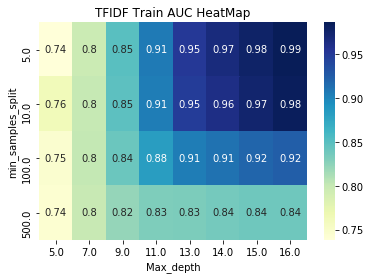

In [70]:
pvt_test = pd.pivot_table(pd.DataFrame(w2v_results),values='mean_train_score', index=X_axis, columns=Y_axis)
#pvt_train = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#fig,ax = plt.subplots(1,2)
sns.heatmap(pvt_test,annot = True,cmap="YlGnBu")
#sns.heatmap(pvt_train,annot = True, ax = ax[1],cmap="YlGnBu")
plt.xlabel('Max_depth')
plt.ylabel('min_samples_split')
plt.title('TFIDF Train AUC HeatMap')

Text(0.5,1,'TFIDF Test AUC HeatMap')

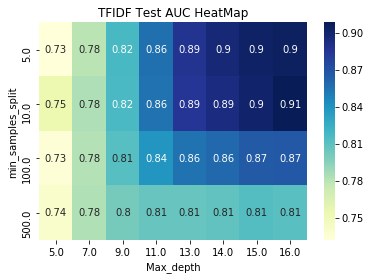

In [71]:
pvt_test = pd.pivot_table(pd.DataFrame(w2v_results),values='mean_test_score', index=X_axis, columns=Y_axis)
#pvt_train = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#fig,ax = plt.subplots(1,2)
sns.heatmap(pvt_test,annot = True,cmap="YlGnBu")
#sns.heatmap(pvt_train,annot = True, ax = ax[1],cmap="YlGnBu")
plt.xlabel('Max_depth')
plt.ylabel('min_samples_split')
plt.title('TFIDF Test AUC HeatMap')

In [86]:
# Fitting the model on test data

test_neigh_tfidf = DecisionTreeClassifier(class_weight = 'balanced' , max_depth = 14,min_samples_split=100)
#test_neigh.set_params(**best_paramList)
test_neigh_tfidf.fit(sent_vect_train,Y_1_train)

predict_test_prob = []
predict_train_prob = []
predicted_labels_test = []
predicted_labels_train = []

# Predicting the model with Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(test_neigh_tfidf.predict(sent_vect_test[j:j+1000]))
    predict_test_prob.extend(test_neigh_tfidf.predict_proba(sent_vect_test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(test_neigh_tfidf.predict(sent_vect_train[k:k+1000]))
    predict_train_prob.extend(test_neigh_tfidf.predict_proba(sent_vect_train[k:k+1000])[:,1])
    
print(len(predict_test_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1_train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)

17555
17555
Algo Run Successfully on D_Test


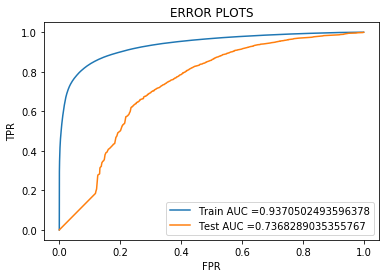

In [87]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [88]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1_train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1_train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
36059 3941 9606 49345
[[36059  3941]
 [ 9606 49345]]
Test Confusion Matrix
1743 1171 3106 11535
[[ 1743  1171]
 [ 3106 11535]]


Text(0.5,1,'Confusion Matrix of Train Data')

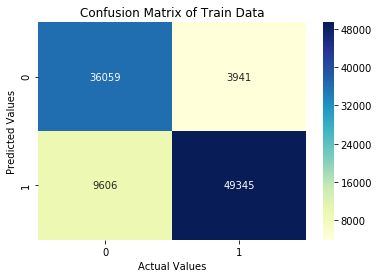

In [89]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

Text(0.5,1,'Confusion Matrix of Test Data')

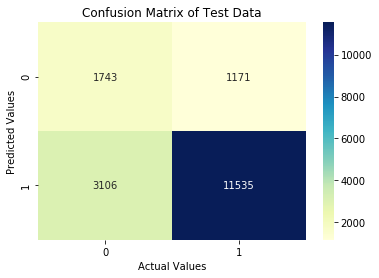

In [90]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Test Data')

##### Feature Importance

In [91]:
importances = test_neigh_tfidf.feature_importances_
indices = np.argsort(importances)[::-1][0:20]
print(indices)
features_w2v = w2v_words
top20_features = []
feature_importance_top20 = []
for i in indices:
    top20_features.append(features_w2v[i])
    feature_importance_top20.append(importances[i])
feature_df = pd.DataFrame(data = top20_features, columns = ['Feature Name'])
feat_imp_df = pd.DataFrame( data = feature_importance_top20 , columns = ['Feature Importance'])
dt_feature_df = pd.concat([feature_df,feat_imp_df],axis = 1)
print(dt_feature_df)

[27 12 23 32 24  9  4 10 34 14 26 49 43 38 45  6 33 15 41 28]
   Feature Name  Feature Importance
0      touching            0.215858
1          gone            0.121118
2       surface            0.065315
3       product            0.052360
4        sticky            0.046914
5        within            0.035865
6         flies            0.029295
7          days            0.026058
8           use            0.022544
9          long            0.021311
10        avoid            0.017435
11      instead            0.017168
12     shipment            0.015917
13         asks            0.014922
14       hardly            0.014002
15         trap            0.013838
16  outstanding            0.013610
17         term            0.013504
18       thumbs            0.012788
19       really            0.011838


## 1.4) Applying Decision Tree on Tf-Idf_Weighted-Average_Word2Vec, SET 4

In [92]:
# Splitting the Training Data into sentences
list_of_sentence = []
for sentence in X_Train['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

98951


In [93]:
# Tf-Idf Weighted Word2Vec for Training Data

tf_idf_features = tfidf_vect.get_feature_names()
dictionary = dict(zip(tfidf_vect.get_feature_names(), list(tfidf_vect.idf_)))

tfidf_w2v_train = []
for sent in tqdm(list_of_sentence):
    sent_vec = np.zeros(50)
    weighted_sum = 0
    for word in sent:
        if word in w2v_words and word in tf_idf_features:
            vec = w2v_model.wv[word]
            tfidf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += vec * tfidf
            weighted_sum += tfidf
    if weighted_sum != 0:
        sent_vec /= weighted_sum
    tfidf_w2v_train.append(sent_vec)
print(len(tfidf_w2v_train))

100%|██████████████████████████████████████████████████████████████████████████| 98951/98951 [3:53:32<00:00,  7.06it/s]


98951


In [94]:
# Splitting the Test Data into sentences

list_of_sentence = []
for sentence in X_test['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

17555


In [95]:
# Tf-Idf Weighted Word2Vec for Test Data

tf_idf_features = tfidf_vect.get_feature_names()

tfidf_w2v_test = []
for sent in tqdm(list_of_sentence):
    sent_vec = np.zeros(50)
    weighted_sum = 0
    for word in sent:
        if word in w2v_words and word in tf_idf_features:
            vec = w2v_model.wv[word]
            tfidf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += vec * tfidf
            weighted_sum += tfidf
    if weighted_sum != 0:
        sent_vec /= weighted_sum
    tfidf_w2v_test.append(sent_vec)
print(len(tfidf_w2v_test))

100%|████████████████████████████████████████████████████████████████████████████| 17555/17555 [24:14<00:00, 15.51it/s]


17555


In [96]:
n_train = len(tfidf_w2v_train)
n_test = len(tfidf_w2v_test)
print(n_train)
print(n_test)

98951
17555


In [73]:
'''tfidf_w2v_train = np.hstack((tfidf_w2v_train,X_Train_count,X_Train_summary_count))
tfidf_w2v_test = np.hstack((tfidf_w2v_test,X_Test_count,X_Test_summary_count))'''

'tfidf_w2v_train = np.hstack((tfidf_w2v_train,X_Train_count,X_Train_summary_count))\ntfidf_w2v_test = np.hstack((tfidf_w2v_test,X_Test_count,X_Test_summary_count))'

In [74]:
'''from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
scaler.fit(tfidf_w2v_train)
tfidf_w2v_train = scaler.transform(tfidf_w2v_train)
tfidf_w2v_test = scaler.transform(tfidf_w2v_test)'''

'from sklearn.preprocessing import MaxAbsScaler\nscaler = MaxAbsScaler()\nscaler.fit(tfidf_w2v_train)\ntfidf_w2v_train = scaler.transform(tfidf_w2v_train)\ntfidf_w2v_test = scaler.transform(tfidf_w2v_test)'

In [75]:
'''tfidf_w2v_train=tfidf_w2v_train.astype('int')
tfidf_w2v_test=tfidf_w2v_test.astype('int')
Y_1=Y_1.astype('int')
Y_test=Y_test.astype('int')'''

"tfidf_w2v_train=tfidf_w2v_train.astype('int')\ntfidf_w2v_test=tfidf_w2v_test.astype('int')\nY_1=Y_1.astype('int')\nY_test=Y_test.astype('int')"

In [97]:
# Using GridSearchCV
tfidfw2v_model_gs = GridSearchCV(DecisionTreeClassifier(class_weight = 'balanced', max_features = 'auto'),tuned_param,cv = 5, scoring = 'roc_auc')
tfidfw2v_model_gs.fit(tfidf_w2v_train,Y_1_train)

print(tfidfw2v_model_gs.best_estimator_)
print("AUC SCORE : ",tfidfw2v_model_gs.score(tfidf_w2v_test,Y_test))

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
AUC SCORE :  0.6451877647116622


In [98]:
tfidfw2v_results = tfidfw2v_model_gs.cv_results_
print(tfidfw2v_results)

{'mean_fit_time': array([1.18454213, 0.61387658, 0.58764968, 0.59821081, 0.75656681,
       0.77765665, 0.74645596, 0.74777827, 0.89966578, 0.88734794,
       0.89544697, 0.88646069, 1.01885467, 0.99769192, 0.99943981,
       0.9140028 , 1.11387758, 1.12375216, 1.07473545, 0.97829151,
       1.16263237, 1.17239184, 1.12105384, 0.9502212 , 1.17740364,
       1.16825733, 1.15278182, 0.97653008, 1.20502243, 1.22488613,
       1.19165363, 0.99708672]), 'std_fit_time': array([1.16046265, 0.02580213, 0.01225359, 0.01650906, 0.03254483,
       0.03223847, 0.01716135, 0.01905651, 0.01898555, 0.02034322,
       0.01885342, 0.05664068, 0.02399999, 0.01187302, 0.00653749,
       0.01112154, 0.01632922, 0.01771475, 0.01462984, 0.01951364,
       0.01648722, 0.05500067, 0.03000814, 0.01589524, 0.01052364,
       0.01338994, 0.03080336, 0.03380788, 0.02306907, 0.03593988,
       0.02872519, 0.03711574]), 'mean_score_time': array([0.22811995, 0.02289524, 0.02602124, 0.02599092, 0.06494908,
       0.0

       0.0031908 , 0.00527707])}


In [99]:
Y_axis = np.array(tfidfw2v_results['param_max_depth'].data, dtype='float')
X_axis = np.array(tfidfw2v_results['param_min_samples_split'].data, dtype='float')

Text(0.5,1,'TFIDF-W2V Train AUC HeatMap')

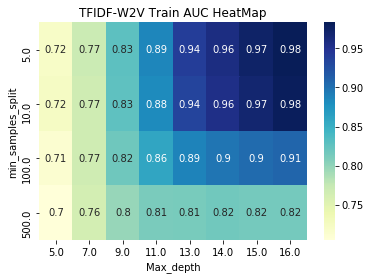

In [100]:
pvt_test = pd.pivot_table(pd.DataFrame(tfidfw2v_results),values='mean_train_score', index=X_axis, columns=Y_axis)
#pvt_train = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#fig,ax = plt.subplots(1,2)
sns.heatmap(pvt_test,annot = True,cmap="YlGnBu")
#sns.heatmap(pvt_train,annot = True, ax = ax[1],cmap="YlGnBu")
plt.xlabel('Max_depth')
plt.ylabel('min_samples_split')
plt.title('TFIDF-W2V Train AUC HeatMap')

Text(0.5,1,'TFIDF-W2V Test AUC HeatMap')

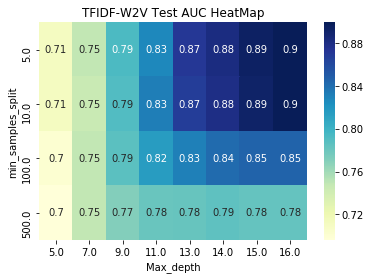

In [101]:
pvt_test = pd.pivot_table(pd.DataFrame(tfidfw2v_results),values='mean_test_score', index=X_axis, columns=Y_axis)
#fig,ax = plt.subplots(1,2)
sns.heatmap(pvt_test,annot = True,cmap="YlGnBu")
#sns.heatmap(pvt_train,annot = True, ax = ax[1],cmap="YlGnBu")
plt.xlabel('Max_depth')
plt.ylabel('min_samples_split')
plt.title('TFIDF-W2V Test AUC HeatMap')

In [102]:
# Fitting the model on test data

test_neigh_tfidf = DecisionTreeClassifier(class_weight = 'balanced', max_depth = 15, min_samples_split=100)
#test_neigh.set_params(**best_paramList)
test_neigh_tfidf.fit(tfidf_w2v_train,Y_1_train)

predict_test_prob = []
predict_train_prob = []
predicted_labels_test = []
predicted_labels_train = []

# Predicting the model with Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(test_neigh_tfidf.predict(tfidf_w2v_test[j:j+1000]))
    predict_test_prob.extend(test_neigh_tfidf.predict_proba(tfidf_w2v_test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(test_neigh_tfidf.predict(tfidf_w2v_train[k:k+1000]))
    predict_train_prob.extend(test_neigh_tfidf.predict_proba(tfidf_w2v_train[k:k+1000])[:,1])
    
print(len(predict_train_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1_train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)

98951
17555
Algo Run Successfully on D_Test


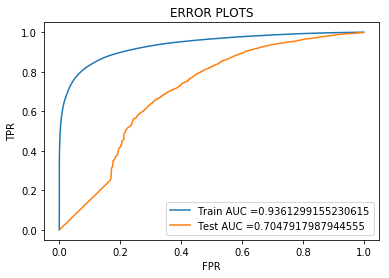

In [103]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [104]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1_train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1_train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
36125 3875 9987 48964
[[36125  3875]
 [ 9987 48964]]
Test Confusion Matrix
1619 1295 3217 11424
[[ 1619  1295]
 [ 3217 11424]]


Text(0.5,1,'Confusion Matrix of Train Data')

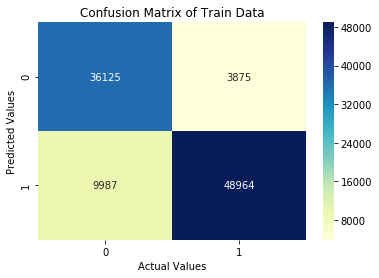

In [105]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

Text(0.5,1,'Confusion Matrix of Test Data')

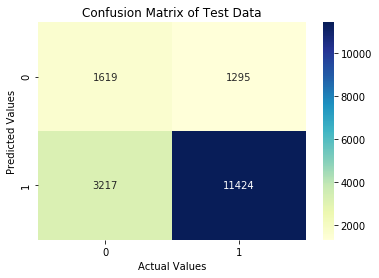

In [106]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Test Data')

## Conclusion

In [107]:
# Importing Pretty Table
from prettytable import PrettyTable

In [108]:
x = PrettyTable()
x.field_names = ['Vectorizer', 'Hyper-Parameter Depth','Hyper-Parameter Min Samples Split','AUC']
x.add_row(['BOW','15','500','0.78'])
x.add_row(['Tf-Idf','15','100','0.78'])
x.add_row(['Average Word2Vec','14','100','0.74'])
x.add_row(['Tf-Idf_Average_Word2Vec','15','100','0.70'])

print(x)

+-------------------------+-----------------------+-----------------------------------+------+
|        Vectorizer       | Hyper-Parameter Depth | Hyper-Parameter Min Samples Split | AUC  |
+-------------------------+-----------------------+-----------------------------------+------+
|           BOW           |           15          |                500                | 0.78 |
|          Tf-Idf         |           15          |                100                | 0.78 |
|     Average Word2Vec    |           14          |                100                | 0.74 |
| Tf-Idf_Average_Word2Vec |           15          |                100                | 0.70 |
+-------------------------+-----------------------+-----------------------------------+------+


##### We have sampled top 100k datapoints that are highly imbalanced. We have upsampled only the  training data explicilty.

##### We have tried to do feature engineering on Tfidf vectorizer but the performance of the model is decreasing a lot. AUC value decreased rapidly. The confusion matrix became worse with a very less true negative rate and a very high false positive rate. So we didnt go ahead with feature engineering for the final version.
##### Same for Word2Vec and Tfidf_Word2Vec vectorizer. This is the reason we didnt include feature engineering in the final version.
##### We have also performed a feature importance to check if the model is performing good. We have listed the top 20 features along with their weight vector values.
##### We have also visualized the decision tree for BOW and TFIDF Vectorizer model with Graphviz. For the visualization purpose only we have limited the max_depth of the tree to 3.